In [1]:
from systemclass import SNAIL,SNAILC,SNAIL_sweep,SNAILC_sweep,Cavity
import numpy as np
from qutip import *
import matplotlib.pyplot as plt

In [2]:
EJ = 70*2*np.pi
EC = 0.177*2*np.pi
beta = 0.12
ng = 0
ncut = 300
flux = 0.48
N = 3
dims = 10

# truncated_dim:int = 6
snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)

omega_c1 = 7*2*np.pi
g_int1 = 0.15*2*np.pi
dimc1 = 5
trunc1 = 50
cavity1 = Cavity(omega_c1,g_int1,dimc1)

omega_c2 = 3*2*np.pi
g_int2 = 0.15*2*np.pi
dimc2 = 100
trunc2 = dims*dimc2
cavity2 = Cavity(omega_c2,g_int2,dimc2)

In [3]:
flux_values = np.linspace(0.42, 0.428, 10)
Hss = []
charge_ops = []
snail_freqs = []
snail_freqs2 = []
for flux in flux_values:
    snail_back = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)
    snail_freqs.append(snail_back.omegas)
    H, op = snail_back.spectrum_charge()
    snail_freqs2.append(H[2,2]/2/np.pi)
    snailc =  SNAILC(snail_back, cavity1, trunc1)
    snailc.parameters()
    Hs , charge_op = snailc.dressed_H, snailc.dressed_charge
    Hss.append(Hs)
    charge_ops.append(charge_op)

In [4]:
len(Hss[0])

50

In [5]:
def find_best_b_and_k(a, B, omega):
    min_diff = float('inf')  # Initialize with a very large number
    best_b = None
    best_k = None

    # Iterate over each element in B
    for b in B:
        # Iterate over each k in the range [-1000, 1000]
        for k in range(-1000, 1001):  # 1001 is used to include 1000 in the range
            diff = abs(a - (b + k * omega))
            # Update min_diff and best_b if a smaller difference is found
            if diff < min_diff:
                min_diff = diff
                best_b = b
                best_k = k

    return best_b, best_k, min_diff

In [6]:
import qutip as qt  
def find_optimal_k(A, B, D):
    # Define a large initial minimum difference
    min_diff = float('inf')
    optimal_k = None
    
    # Iterate over a range of possible k values
    # The range can be adjusted based on expected size of k or other insights you have about your problem
    for k in range(-1000, 1000):
        # Calculate the difference for this value of k
        diff = abs(A - (B + k * D))
        
        # If this is the smallest difference we've found so far, update min_diff and optimal_k
        if diff < min_diff:
            min_diff = diff
            optimal_k = k
            
    return optimal_k
# Function to calculate overlap (you might use inner product, fidelity, etc.)
def calculate_overlap(state1, state2):
    return abs((state1.dag() * state2)[0,0])**2
def floquet_spec(Hs,Hc, omega, A,omegas):
#     Hs[0][0] = Hs[0][0]+Hs[1][1]
#     Hs[1][1] = Hs[1][1]+Hs[1][1]
    energy = np.diag(Hs)
    indexs1 = np.argmin(np.abs(energy - omegas * np.ones(len(energy))))
    indexc1 = np.argmin(np.abs(energy - omega_c1 * np.ones(len(energy))))
    indexc2 = np.argmin(np.abs(energy - 2 * omega_c1 * np.ones(len(energy))))
    indexsc = np.argmin(np.abs(energy - (omegas+omega_c1) * np.ones(len(energy))))
    Hs = Qobj(Hs)
    
    Hc = Qobj(charge_op)
    args = {'w': omega}
    T = (2*np.pi)/omega
    H = [Hs,  [Hc, lambda t, args: A*np.cos(args['w']*t)],] 
    options = Options(nsteps=100000)  # Increasing nsteps to 10000, adjust as needed
    f_modes, f_energies = floquet_modes(H, T, args, True, options=options) 
    basis_states = [qt.basis(trunc1, 0),qt.basis(trunc1, indexs1),qt.basis(trunc1,indexc1),qt.basis(trunc1,indexc2),qt.basis(trunc1,indexsc)]
    
    # Initialize a list to hold the indices of the Floquet states with the maximum overlap for each basis state
    max_overlap_indices = [-1] * 6
    max_overlaps = [0] * 6
    # Loop over each Floquet state
    for f_index, f_state in enumerate(f_modes):
        # Loop over each basis state
        for b_index, b_state in enumerate(basis_states):
            # Calculate the overlap
            overlap = calculate_overlap(f_state, b_state)

            # If this is the maximum overlap for this basis state, store the index
            if overlap > max_overlaps[b_index]:
                max_overlaps[b_index] = overlap
                max_overlap_indices[b_index] = f_index
    energyg = f_energies[max_overlap_indices[0]]/2/np.pi
    
    energys1 = f_energies[max_overlap_indices[1]]/2/np.pi
    k = find_optimal_k(omega_c1/2/np.pi, energys1, omega/2/np.pi)
    energys1 = energys1 + k*omega/2/np.pi - energyg
    
    energyc1 = f_energies[max_overlap_indices[2]]/2/np.pi
    k = find_optimal_k(omega_c1/2/np.pi, energyc1, omega/2/np.pi)
    energyc1 = energyc1 + k*omega/2/np.pi - energyg
    
    energysc = f_energies[max_overlap_indices[4]]/2/np.pi
    k = find_optimal_k((omega_c1+omegas)/2/np.pi, energysc, omega/2/np.pi)
    starkshift = energysc - energyg + k*omega/2/np.pi - energyc1 - energys1
    
    energyc2 = f_energies[max_overlap_indices[3]]/2/np.pi
    k = find_optimal_k(2*omega_c1/2/np.pi, energyc2, omega/2/np.pi)
    energyc2 = energyc2 +k*omega/2/np.pi
    selfkerr = energyc2-energyg - 2*energyc1
    
#     print(f_energies[max_overlap_indices[1]],f_energies[max_overlap_indices[0]])
    return energyc1, starkshift, selfkerr

In [7]:
omega = 4.9*2*np.pi
A = 0.01*2*np.pi
floquet_results = []
for i in range(len(flux_values)):
    floquet_results.append(floquet_spec(Hss[i],charge_ops[i], omega, A,snail_freqs[i]))

14.0
14.0
14.0
14.0
14.0
14.0
14.0
14.0
14.0
14.0


In [8]:
floquet_results = np.array(floquet_results)

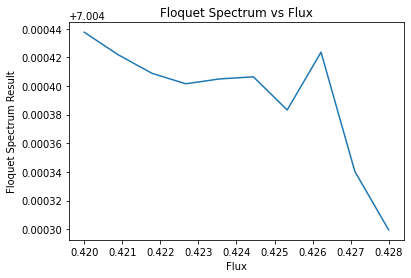

In [9]:
# Plotting
plt.plot(flux_values, floquet_results[:,0], )
# plt.plot(flux_values, -(floquet_results/2/np.pi)[:,4]+(floquet_results/2/np.pi)[:,7])
plt.xlabel('Flux')
plt.ylabel('Floquet Spectrum Result')
plt.title('Floquet Spectrum vs Flux')
# plt.ylim(2.992,2.9929)
plt.show()

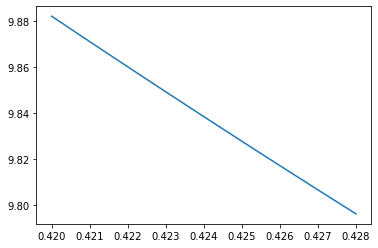

In [10]:
plt.plot(flux_values,np.array(snail_freqs2))

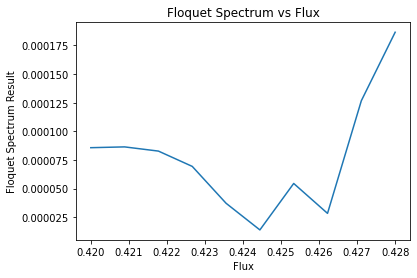

In [11]:
# Plotting
plt.plot(flux_values, floquet_results[:,1], )
# plt.plot(flux_values, -(floquet_results/2/np.pi)[:,4]+(floquet_results/2/np.pi)[:,7])
plt.xlabel('Flux')
plt.ylabel('Floquet Spectrum Result')
plt.title('Floquet Spectrum vs Flux')
# plt.ylim(-2e-6,1e-6)
plt.show()

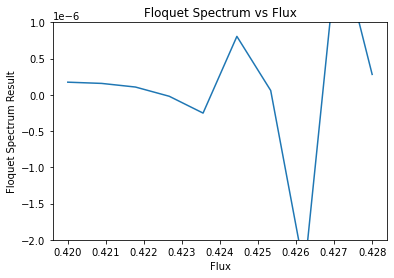

In [12]:
# Plotting
plt.plot(flux_values, floquet_results[:,2], )
# plt.plot(flux_values, -(floquet_results/2/np.pi)[:,4]+(floquet_results/2/np.pi)[:,7])
plt.xlabel('Flux')
plt.ylabel('Floquet Spectrum Result')
plt.title('Floquet Spectrum vs Flux')
plt.ylim(-2e-6,1e-6)
plt.show()